# Load in modules

In [9]:
import keras 
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Dense, BatchNormalization, Identity, Input, GlobalAveragePooling2D, \
    RandomSharpness, RandomRotation, RandomFlip, ReLU
from keras.activations import relu
from keras.optimizers import AdamW
from keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #Tensorflow yaps too much


# Load in Data
Here we will load in the data and convert it to a scale of [0, 1]. To reduce the effect of the light spot on the images and increase the contrast between light and dark areas we will use the following function: $img_{new} = (img - 0.2)^{2}$

I0000 00:00:1761661444.397352   12901 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6166 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


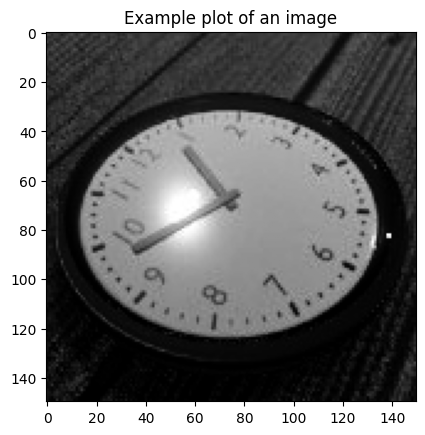

In [2]:
#Converted the image values to a range of [0, 1], better for network to work with
X, y = np.load('data_150/images.npy')/255.0, np.load('data_150/labels.npy')
X_c, y_c = X.copy(), y.copy()
#Simple function to improve the contrast of an img
class ImproveContrast(keras.layers.Layer):
    def __init__(self, alpha=0.2):
        super().__init__()
        self.alpha = alpha
    
    def call(self, x):
        x = (x-self.alpha)**2
        x = tf.where(x < 0, 0.0, x)
        return x
    

plt.title('Example plot of an image')
x = tf.expand_dims(X.copy()[1200], axis=-1)
plt.imshow(ImproveContrast().call(x), cmap='grey')

# Classification and Double Head Network

## Load in Data

In [3]:
X = X.astype("float32") 
X = X[..., np.newaxis]

# Classification CNN

In [ ]:
def time_to_label(y, label_range):
    y=y.copy()
    num_classes = 12*60//label_range
    label=(y[:,0]*60 + y[:,1])//label_range
    return label, num_classes

print(X[0].shape)

(150, 150, 1)


In [5]:
#x = np.expand_dims(X[1200],axis=0)
#x = keras.layers.AveragePooling2D(2,2)(x)
#x = np.squeeze(x)

#plt.imshow(x, cmap="grey")

In [ ]:
for min_accuracy in [30, 10, 5]:

    # --- Prepare datasets ---
    y_labels, number_of_classifiers = time_to_label(y, min_accuracy)
    X_traina, X_test, y_traina, y_test = train_test_split(
        X, y_labels, test_size=0.1, random_state=42, shuffle=True
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_traina, y_traina, test_size=y_test.shape[0], random_state=42, shuffle=True
    )

    # --- Function to build model (with or without initial AveragePooling) ---
    def make_model(include_pool=True):
        layers_list = []

        # Add the first pooling layer only for "base" models
        if include_pool:
            layers_list.append(keras.layers.AveragePooling2D(2,2))

        # Convolutional backbone
        layers_list += [
            keras.layers.Conv2D(32, (5,5), padding="same", input_shape=X_train[0].shape),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.MaxPooling2D(),

            keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.AveragePooling2D(2,2),

            keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.AveragePooling2D(2,2),

            keras.layers.Conv2D(256, (3,3), padding="same", activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.AveragePooling2D(2,2),

            GlobalAveragePooling2D(),
            Dense(128, activation="relu", kernel_regularizer=l2(1e-4)),
            Dropout(0.4),
            Dense(number_of_classifiers, activation="softmax")
        ]

        # Compile the model
        model = keras.Sequential(layers_list)
        model.compile(
            optimizer=AdamW(learning_rate=5e-4, weight_decay=5e-5),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        return model

    # --- Train both variants: base (with pooling) and _full (without pooling) ---
    for include_pool, suffix in [(True, ""), (False, "_full")]:
        model = make_model(include_pool)

        callbacks = [
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
            ModelCheckpoint(f"classifier_{min_accuracy}{suffix}.keras", save_best_only=True),
            EarlyStopping(patience=10, restore_best_weights=True)
        ]

        tf.keras.backend.clear_session()

        print(f"Training classifier_{min_accuracy}{suffix} ...")
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        # Save training history to CSV
        hist_df = pd.DataFrame(history.history)
        hist_df.to_csv(f"classifier_{min_accuracy}{suffix}.csv", index=False)


/vol/home/s4949404/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.0842 - loss: 3.0115 - val_accuracy: 0.0450 - val_loss: 8.1769 - learning_rate: 5.0000e-04
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.1789 - loss: 2.4796 - val_accuracy: 0.0411 - val_loss: 9.6008 - learning_rate: 5.0000e-04
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2582 - loss: 2.1472 - val_accuracy: 0.0678 - val_loss: 3.6273 - learning_rate: 5.0000e-04
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3701 - loss: 1.7995 - val_accuracy: 0.0906 - val_loss: 4.2213 - learning_rate: 5.0000e-04
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5141 - loss: 1.3885 - val_accuracy: 0.0511 - val_loss: 11.0217 - learning_rate: 5.0000e-04
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6379 - loss: 1.0390 - val_accuracy: 0.1111 - val_loss: 5.0954 - learning_rate: 5.0000e-04
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/st

## Figures and test performance

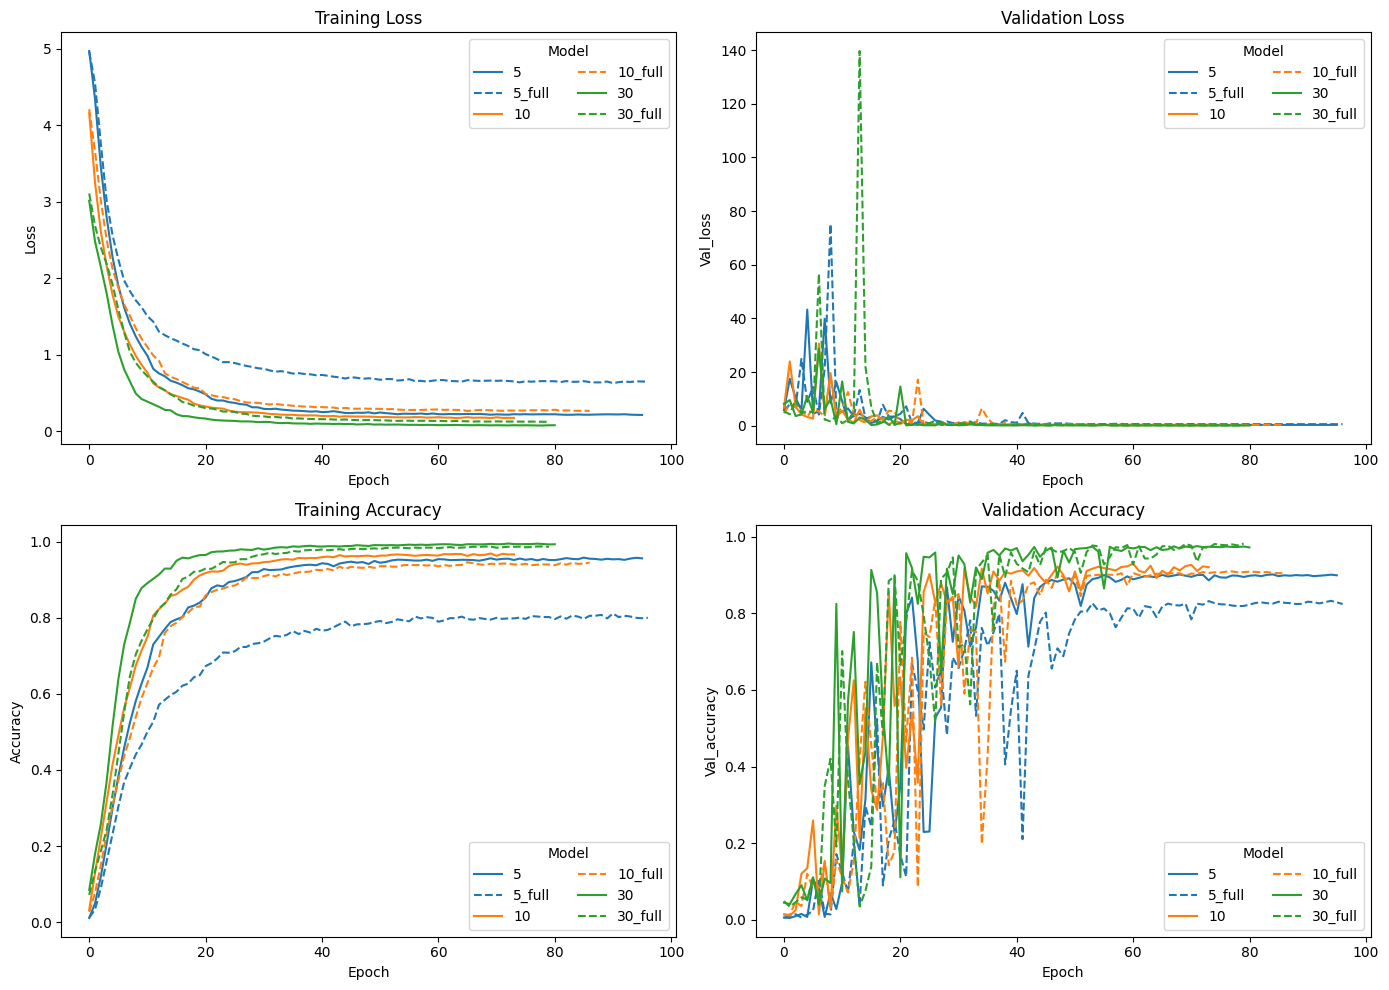

In [16]:
#read files: 
files_all = sorted(glob.glob("classifier_*.csv"))
files_base = [f for f in files_all if "_full" not in f]
files_full = [f for f in files_all if "_full" in f]

# Ordine numerico desiderato
orders = [5, 10, 30]

# Mappa colori coerente per ogni valore di min_accuracy
colors = {5: "tab:blue", 10: "tab:orange", 30: "tab:green"}

def label_from_file(f):
    return f.replace("classifier_", "").replace(".csv", "")

plt.figure(figsize=(14,10))

# Helper per plottare
def plot_metric(metric, title, pos):
    plt.subplot(2,2,pos)
    for val in orders:
        # Base
        base = f"classifier_{val}.csv"
        full = f"classifier_{val}_full.csv"
        if base in files_base:
            df = pd.read_csv(base)
            plt.plot(df[metric], "-", color=colors[val], label=f"{val}")
        if full in files_full:
            df = pd.read_csv(full)
            plt.plot(df[metric], "--", color=colors[val], label=f"{val}_full")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend(title="Model", ncol=2)

# --- 4 plot ---
plot_metric("loss", "Training Loss", 1)
plot_metric("val_loss", "Validation Loss", 2)
plot_metric("accuracy", "Training Accuracy", 3)
plot_metric("val_accuracy", "Validation Accuracy", 4)

plt.tight_layout()
plt.show()

# Multi Headed Network

In [ ]:
def time_to_label(y, label_range):
    label = y.copy()
    label[:,1] = label[:,1] // label_range
    num_classes = (60 // label_range) * 12

    # Map hours and quantized minutes into a single label index
    labels_flat = label[:,0] * (60 // label_range) + label[:,1]

    return np.array(labels_flat, dtype=int), num_classes

In [24]:
for min_accuracy in [30, 10, 5]:

    # --- Prepare datasets ---
    y_labels, number_of_classifiers = time_to_label(y, min_accuracy)
    X_traina, X_test, y_traina, y_test = train_test_split(
        X, y_labels, test_size=0.1, random_state=42, shuffle=True
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_traina, y_traina, test_size=y_test.shape[0], random_state=42, shuffle=True
    )

    # --- Function to build a double-head model ---
    def make_double_head_model(include_pool=True):
        """Builds a CNN with two classification heads: hours and minutes."""
        layers_list = []

        # Optional initial pooling layer (only for base models)
        if include_pool:
            layers_list.append(keras.layers.AveragePooling2D(2, 2))

        # Shared convolutional backbone
        layers_list += [
            keras.layers.Conv2D(32, (5,5), padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.MaxPooling2D(),

            keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.AveragePooling2D(2,2),

            keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.AveragePooling2D(2,2),

            keras.layers.Conv2D(256, (3,3), padding="same", activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.AveragePooling2D(2,2),

            keras.layers.GlobalAveragePooling2D(),
            Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4)),
            Dropout(0.4),
        ]

        # Shared feature extractor
        body = keras.Sequential(layers_list, name="shared_body")

        # Hours head (12 classes)
        hours_head = keras.Sequential([
            Dense(12, activation="softmax")
        ], name="hours")

        # Minutes head (depends on label granularity)
        minutes_head = keras.Sequential([
            Dense(number_of_classifiers, activation="softmax")
        ], name="minutes")

        # Define full model connections
        inputs = keras.Input(shape=X[0].shape)
        features = body(inputs)
        out_hours = hours_head(features)
        out_minutes = minutes_head(features)

        model = keras.Model(inputs=inputs, outputs=[out_hours, out_minutes])

        # Compile with two categorical losses and accuracy metrics
        model.compile(
            optimizer=AdamW(learning_rate=5e-4, weight_decay=5e-5),
            loss={
                "hours": "sparse_categorical_crossentropy",
                "minutes": "sparse_categorical_crossentropy"
            },
            metrics={
                "hours": ["accuracy"],
                "minutes": ["accuracy"]
            }
        )
        return model

    # --- Train both base (with pooling) and _full (without) versions ---
    for include_pool, suffix in [(True, ""), (False, "_full")]:
        tf.keras.backend.clear_session()

        model = make_double_head_model(include_pool)

        callbacks = [
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
            ModelCheckpoint(f"double_head_{min_accuracy}{suffix}.keras", save_best_only=True),
            EarlyStopping(patience=15, restore_best_weights=True)
        ]

        print(f"Training double_head_{min_accuracy}{suffix} ...")
        history = model.fit(
            X_train, [y_train[:,0], y_train[:,1]],
            epochs=100,
            batch_size=64,
            validation_data=(X_val, [y_val[:,0], y_val[:,1]]),
            callbacks=callbacks,
            verbose=1
        )

        # Save training history to CSV
        hist_df = pd.DataFrame(history.history)
        hist_df.to_csv(f"double_head_{min_accuracy}{suffix}.csv", index=False)



Training double_head_30 ...
Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - hours_accuracy: 0.1284 - hours_loss: 2.3918 - loss: 2.9591 - minutes_accuracy: 0.7024 - minutes_loss: 0.5504 - val_hours_accuracy: 0.0811 - val_hours_loss: 5.6158 - val_loss: 9.7831 - val_minutes_accuracy: 0.5117 - val_minutes_loss: 4.1517 - learning_rate: 5.0000e-04
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - hours_accuracy: 0.2011 - hours_loss: 2.1585 - loss: 2.5990 - minutes_accuracy: 0.7977 - minutes_loss: 0.4233 - val_hours_accuracy: 0.0867 - val_hours_loss: 4.9865 - val_loss: 8.8500 - val_minutes_accuracy: 0.5117 - val_minutes_loss: 3.8405 - learning_rate: 5.0000e-04
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - hours_accuracy: 0.2886 - hours_loss: 1.8897 - loss: 2.2462 - minutes_accuracy: 0.8442 - minutes_loss: 0.3385 - val_hours_accuracy: 0.1417 - val_hours_loss: 2.5655 - val_loss: 3.3541 - val_minutes_accuracy: 0.6372 - val_minutes_loss: 0.7752 - learning_rate: 5.0000e-04


2025-10-28 17:42:38.703508: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - hours_accuracy: 0.0841 - hours_loss: 2.5821 - loss: 2.7535 - minutes_accuracy: 0.9767 - minutes_loss: 0.1543

2025-10-28 17:42:43.993556: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-28 17:42:44.321570: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 144 bytes spill stores, 144 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - hours_accuracy: 0.0964 - hours_loss: 2.5320 - loss: 2.6023 - minutes_accuracy: 0.9961 - minutes_loss: 0.0533 - val_hours_accuracy: 0.0811 - val_hours_loss: 3.5011 - val_loss: 3.5106 - val_minutes_accuracy: 1.0000 - val_minutes_loss: 7.5559e-05 - learning_rate: 5.0000e-04
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - hours_accuracy: 0.1647 - hours_loss: 2.2951 - loss: 2.3244 - minutes_accuracy: 1.0000 - minutes_loss: 0.0124 - val_hours_accuracy: 0.0861 - val_hours_loss: 4.2412 - val_loss: 4.2506 - val_minutes_accuracy: 1.0000 - val_minutes_loss: 6.4198e-06 - learning_rate: 5.0000e-04
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - hours_accuracy: 0.2625 - hours_loss: 1.9732 - loss: 1.9968 - minutes_accuracy: 1.0000 - minutes_loss: 0.0065 - val_hours_accuracy: 0.0789 - val_hours_loss: 6.2594 - val_loss: 6.2551 - val_minutes_accuracy: 1.0000 - val_minutes_loss: 3.8589e-07 - learning_rate: 5.0000e-04
Epoch 4/100
225/225 ━━━━━━━━

KeyboardInterrupt: 

## Figures and test performance

In [ ]:
# --- Read all CSVs ---
csv_files = sorted(glob.glob("double_head_*.csv"))

plt.figure(figsize=(16,10))

# --- PLOT 1: Total training/validation loss ---
plt.subplot(2,2,1)
for f in csv_files:
    df = pd.read_csv(f)
    label = f.replace("double_head_", "").replace(".csv", "")
    linestyle = "--" if "full" in f else "-"
    plt.plot(df["loss"], linestyle, label=f"Train {label}")
    plt.plot(df["val_loss"], linestyle, alpha=0.5, label=f"Val {label}")
plt.title("Total Loss (Training & Validation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(ncol=2)

# --- PLOT 2: Hours head loss ---
plt.subplot(2,2,2)
for f in csv_files:
    df = pd.read_csv(f)
    label = f.replace("double_head_", "").replace(".csv", "")
    linestyle = "--" if "full" in f else "-"
    plt.plot(df["hours_loss"], linestyle, label=f"Train {label}")
    plt.plot(df["val_hours_loss"], linestyle, alpha=0.5, label=f"Val {label}")
plt.title("Hours Head Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(ncol=2)

# --- PLOT 3: Minutes head loss ---
plt.subplot(2,2,3)
for f in csv_files:
    df = pd.read_csv(f)
    label = f.replace("double_head_", "").replace(".csv", "")
    linestyle = "--" if "full" in f else "-"
    plt.plot(df["minutes_loss"], linestyle, label=f"Train {label}")
    plt.plot(df["val_minutes_loss"], linestyle, alpha=0.5, label=f"Val {label}")
plt.title("Minutes Head Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(ncol=2)

# --- PLOT 4: Accuracies (hours vs minutes) ---
plt.subplot(2,2,4)
for f in csv_files:
    df = pd.read_csv(f)
    label = f.replace("double_head_", "").replace(".csv", "")
    linestyle = "--" if "full" in f else "-"
    plt.plot(df["hours_accuracy"], linestyle, label=f"H_train {label}")
    plt.plot(df["minutes_accuracy"], linestyle, label=f"M_train {label}")
    plt.plot(df["val_hours_accuracy"], linestyle, alpha=0.5, label=f"H_val {label}")
    plt.plot(df["val_minutes_accuracy"], linestyle, alpha=0.5, label=f"M_val {label}")
plt.title("Hours vs Minutes Accuracy (Train & Val)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(ncol=2, fontsize=8)

plt.tight_layout()
plt.show()


# Label Transformation

In [ ]:
def to_cos_sin(y, label_range):
    y = y.copy()
    label_range=30 #minutes the are togheter in the same class
    number_of_classifiers=12*60//label_range

    hours_decimal=y[:,0]+y[:,1]/60
    hours_normalized=hours_decimal/12
    hours_angolized=hours_normalized*2*np.pi
    labels=np.column_stack((np.cos(hours_angolized), np.sin(hours_angolized)))  
    return labels, number_of_classifiers

def angular_mse(y_true, y_pred):
    # sicurezza: normalizza su cerchio
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    th_t = tf.atan2(y_true[...,1], y_true[...,0])  # atan2(sin, cos)
    th_p = tf.atan2(y_pred[...,1], y_pred[...,0])
    d   = tf.atan2(tf.sin(th_p - th_t), tf.cos(th_p - th_t))  # wrap in (−π, π]
    return tf.reduce_mean(tf.square(d)) 


def angular_mae_minutes(y_true, y_pred):
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    th_t = tf.atan2(y_true[...,1], y_true[...,0])
    th_p = tf.atan2(y_pred[...,1], y_pred[...,0])
    d   = tf.atan2(tf.sin(th_p - th_t), tf.cos(th_p - th_t))
    err_min = tf.abs(d) * (12.*60.) / (2.*np.pi)       # minuti su quadrante 12h
    return tf.reduce_mean(err_min)

class CosSin(keras.layers.Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=-1)
    



In [ ]:
# --- Prepare dataset (cos/sin encoding for time) ---
y_labels, number_of_classifiers = to_cos_sin(y, 30)
X_traina, X_test, y_traina, y_test = train_test_split(
    X, y_labels, test_size=0.1, random_state=42, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_traina, y_traina, test_size=y_test.shape[0], random_state=42, shuffle=True
)

# --- Define the CNN model for Cos-Sin regression ---
model_base = keras.models.Sequential([
    # Convolutional feature extractor
    keras.layers.Conv2D(32, (5,5), padding="same", input_shape=X_train[0].shape),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),

    keras.layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dropout(0.3),

    # Two continuous outputs: cos(θ), sin(θ)
    keras.layers.Dense(2),
    CosSin()  # custom normalization layer ensuring unit circle output
])

# --- Compile the model ---
model_base.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=5e-5),
    loss=angular_mse,                 # custom angular mean squared error
    metrics=[angular_mae_minutes]     # custom metric (mean absolute angular error)
)

# --- Callbacks for training control ---
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint("CosSin_model.keras", save_best_only=True),
    EarlyStopping(patience=15, restore_best_weights=True)
]

# --- Train the model ---
print("Training CosSin angular regression model ...")
history_base = model_base.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# --- Save training history to CSV ---
hist_df = pd.DataFrame(history_base.history)
hist_df.to_csv("CosSin.csv", index=False)


## Figures and test performance

In [ ]:
# --- Load the training history ---
df = pd.read_csv("CosSin.csv")

plt.figure(figsize=(12,6))

# --- Plot LOSS ---
plt.subplot(1,2,1)
plt.plot(df["loss"], label="Train")
plt.plot(df["val_loss"], "--", label="Validation")
plt.title("Angular MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

# --- Plot ANGULAR ERROR (≈ accuracy proxy) ---
metric_name = [col for col in df.columns if "angular_mae_minutes" in col]
if metric_name:
    plt.subplot(1,2,2)
    plt.plot(df[metric_name[0]], label="Train")
    plt.plot(df[f"val_{metric_name[0]}"], "--", label="Validation")
    plt.title("Angular MAE (minutes)")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error (min)")
    plt.legend()
    plt.grid(alpha=0.3)
else:
    print("Warning: metric 'angular_mae_minutes' not found in CSV")

plt.tight_layout()
plt.show()

# Regression Network

In [ ]:
#Code for Resnet block
class ResBlock(keras.layers.Layer):
    def __init__(self, num_input_layers, num_output_layers, kernel_size):
        super().__init__()
        #For first convolutional layer
        self.conv1 = Conv2D(num_output_layers, kernel_size=kernel_size, padding='same', strides=1, 
                                  kernel_initializer='glorot_uniform')
        self.bn1 = BatchNormalization()
        self.relu = relu

        #For second convolutional layer
        self.conv2 = Conv2D(num_output_layers, kernel_size=kernel_size, padding='same', strides=1, 
                                  kernel_initializer='glorot_uniform')
        self.bn2 = BatchNormalization()

        #If the input and output channels are different, we need to adjust the input
        if num_input_layers != num_output_layers:
            self.shortcut = Conv2D(num_output_layers, kernel_size=1, strides=1, padding='valid')
        else:
            self.shortcut = Identity()
    
    def call(self, x):
        #First convolutional layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        #Second convolutional layer
        x = self.conv2(x)
        x = self.bn2(x)

        #Add shortcut and apply non-linearity
        x += self.shortcut(x)
        x = self.relu(x)

        return x
    
#Code for an Attention block
class AttentionBlock(keras.layers.Layer):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = Conv2D(filters=1, kernel_size=kernel_size, padding = 'same', activation='sigmoid') 
    
    def call(self, x):
        attention = self.conv(x) 
        x *= attention
        return x

In [ ]:
class CNN_regression(keras.Model):
    """Convolutional Neural Network class using residual network blocks"""
    def __init__(self, input_shape=[75, 75, 1], batch_size=64, mode='regression', **kwargs):
        if not isinstance(input_shape, list):
            raise TypeError("input_shape type must be of type 'List'")
         
        if (mode != 'regression') and (mode != 'classification'): #Make shure the mode is always correct
            raise ValueError("The mode of the CNN can either be 'regression' or 'classification'")
        
        if not isinstance(batch_size, int):
            raise TypeError("The batch size must be of type 'int'")

        super().__init__(**kwargs)
        #Just some parameters to keep just in case it is needed later
        self.input_shape = tuple([batch_size] + input_shape)
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.mode = mode

        self.conv_layers = keras.Sequential([
                Input(shape=(self.input_shape)),
                ImproveContrast(0.2),
                
                ResBlock(1, 32, kernel_size=3),
                AttentionBlock(),
                MaxPool2D(pool_size=(2, 2), padding='valid', strides=2),

                ResBlock(32, 64, kernel_size=3),
                AttentionBlock(),
                AvgPool2D(pool_size=(2, 2), strides=2, padding='valid'),

                ResBlock(64, 128, kernel_size=3),
                AttentionBlock(),
                AvgPool2D(pool_size=(2, 2), strides=2, padding='valid'),

                ResBlock(128, 256, kernel_size=3),
                AttentionBlock(),
                GlobalAveragePooling2D(data_format='channels_last')
            
        ])
        
        self.regression_layers = keras.Sequential([
            Input((256,)),
            Dense(300, activation='gelu', kernel_initializer='glorot_normal'),
            Dropout(0.2),
            Dense(150, activation='gelu', kernel_initializer='glorot_normal'),
            Dropout(0.2),
            Dense(1)
        ])


    def call(self, x, training=False):
        x = self.conv_layers(x, training=training)
        if self.mode == 'regression':
            return self.regression_layers(x, training=training)

# Start training for regression

### Split data into train/validation/test set

For regression all the labels will be converted to minutes as unit

In [ ]:
def to_min(x, y):
    y = y[0]*60 + y[1]
    return x, y

with tf.device('/CPU:0'):
    dataset = tf.data.Dataset.from_tensor_slices((X_c, y_c)).map(to_min)
    # Split data into 80/10/10% train/validation/test split
    data_train, data_temp = keras.utils.split_dataset(dataset, 0.8, shuffle=True, seed=42)
    data_valid, data_test = keras.utils.split_dataset(data_temp, 0.5, shuffle=True, seed=42)

    #Convert iterable back to images -> (samples, 75, 75), labels -> (sampels, 2)
    X_train, y_train = next(iter(data_train.batch(len(data_train))))
    X_valid, y_valid = next(iter(data_valid.batch(len(data_valid))))
    X_test, y_test = next(iter(data_test.batch(len(data_test))))


preprocess = keras.Sequential([
        RandomFlip('horizontal_and_vertical'),
        RandomRotation(0.2),
        RandomSharpness((0.7, 0.7), value_range=(0,1)),
    ])

def DataAugment(img, label):
    img = tf.expand_dims(img, axis=-1)
    img = preprocess(img)
    return img, label


### Now compile a CNN model and train it on the data

In [ ]:
def Loss(y, pred):
    #Loss function for regression. This is also the common sense loss
    pred = tf.math.floormod(pred, 720)
    diff = tf.math.minimum(tf.abs(y - pred), 720 - tf.abs(y - pred))
    return tf.reduce_mean(diff + 1e-8)

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 250

train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(1000)
            .map(DataAugment, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE)
            )

valid_ds = (tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE)
            )

optim = AdamW(learning_rate=0.0002)
model = CNN_regression(input_shape=[75,75,1], batch_size=BATCH_SIZE, mode='regression')

model.compile(optimizer=optim, loss=Loss)

model_filepath = './task_2/regression_150.model.keras'
callback = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7), 
            EarlyStopping(patience=71), 
            ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True, mode='min')]

hist = model.fit(train_ds, validation_data=valid_ds, epochs=NUM_EPOCHS, callbacks=callback)
hist_df = pd.DataFrame(hist.history).to_csv('./task_2/regression_history.csv')
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['loss'])


In [ ]:
#Summary of model

model = CNN_regression()

model = keras.models.load_model('./task_2/regression_150.model.keras', 
                                custom_objects={'CNN': CNN_regression, 'Loss': Loss})

In [ ]:
regression_df = pd.read_csv('./task_2/regression_history.csv').iloc[:,1:]
loss_df = regression_df[['loss', 'val_loss']]
lr_df = regression_df['learning_rate']

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(len(loss_df['loss'])), loss_df['loss'], label='train')
ax[0].plot(range(len(loss_df['val_loss'])), loss_df['val_loss'], label='validation')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Common sense loss')
ax[0].legend

ax[1].plot(range(len(lr_df)), lr_df)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('learning rate')

fig.suptitle('Training history of the CNN with a regression head')